## Training

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, fbeta_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap
plt.style.use('default')

def generate_classification_models(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define models to train
    # Add more if you want but note that data is not scaled in this function as of now
    models = {
        'Logistic Regression': LogisticRegression(max_iter=3000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'XGBoost': xgb.XGBClassifier(),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    
    # Create an F2 scorer and scorer dictionary for cross validation scoring
    scorer = {
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall',
        'roc_auc': 'roc_auc',
        'f2': make_scorer(fbeta_score, beta=2)
    }

    # Train each model, perform KFold cross validation for scoring, and store performance metrics
    metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'F2 Score': [], 'ROC AUC': []}
    trained_models = {}
    conf_matrixes = {}
    for name, model in models.items():
        metrics['Model'].append(name)
        cv_method = KFold(n_splits=5, shuffle=True, random_state=42) #adjust n_splits for more folds in validation, will increase computation time
        scores = cross_validate(model, X_train, y_train, cv=cv_method, scoring=scorer, n_jobs=-1) #performs validation testing per the method defined above
        metrics['Accuracy'].append(np.mean(scores['test_accuracy']))
        metrics['Precision'].append(np.mean(scores['test_precision']))
        metrics['Recall'].append(np.mean(scores['test_recall']))
        metrics['F1 Score'].append(np.mean(scores['test_f1']))
        metrics['F2 Score'].append(np.mean(scores['test_f2']))
        metrics['ROC AUC'].append(np.mean(scores['test_roc_auc']))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        trained_models[name] = model
        conf_matrixes[name] = confusion_matrix(y_test, y_pred)
        print("Finished training and cross validating: " + name)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        # Add ROC Curve to plot
        plt.plot(fpr, tpr, label=name)
    # Now that all model curves are plotted, plot the 0.5 line and add labels
    plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Convert metrics dictionary to a pandas DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics)

    # Return a dictionary containing the metrics DataFrame and the trained models
    return {'metrics': metrics_df, 'models': trained_models, 'confusion_matrixes': conf_matrixes, 'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

def get_shap_values(model, X_test, X_train):
    import shap
    explainer = shap.Explainer(model.predict_proba, X_train, feature_names=X_test.columns)
    shap_values = explainer(X_test[:100]) # just choosing the top 100 rows because this is super slow
    return shap_values

In [3]:
df = pd.read_csv('s3://adl-core-sagemaker-studio/external/MSK_marketscan/Unsaved/2023/05/25/3f9a7d4f-9fc3-47ad-b442-c60065634557.csv') #latest iteration, 1:1 no:yes and only surgeries >= 2019
print(df.shape)
print("No group count: "+str(len(df[df['surgery_flag']=='No'])))
print("Yes group count: "+str(len(df[df['surgery_flag']=='Yes'])))
df.head()

(291333, 14)
No group count: 200000
Yes group count: 91333


,enrolid,surgery_flag,age,back_xray,back_mri,spine_injection,physical_therapy,spine_pain,radiculopathy,stenosis,disc_degeneration,segmental_dysfunction,spondylosis,spondylolisthesis
0,591117801,No,72,Yes,No,No,No,No,No,No,No,No,No,No
1,1613366701,No,38,No,No,No,Yes,Yes,Yes,No,No,Yes,No,No
2,1638902101,No,51,Yes,No,Yes,No,Yes,No,No,No,No,No,No
3,591159701,No,79,No,No,No,No,No,No,No,No,No,No,No
4,4450334101,No,80,No,No,No,Yes,No,No,No,No,No,No,No


In [4]:
from sklearn.utils import resample

df_raw_yes = df[df['surgery_flag'] == 'Yes']
df_raw_no = df[df['surgery_flag'] == 'No']
if len(df_raw_no) > len(df_raw_yes):   
    df_downsampled = resample(df_raw_no, replace=False, n_samples=len(df_raw_yes), random_state=42)
    df = pd.concat([df_raw_yes, df_downsampled])
elif len(df_raw_yes) > len(df_raw_no):
    df_downsampled = resample(df_raw_yes, replace=False, n_samples=len(df_raw_no), random_state=42)
    df = pd.concat([df_raw_no, df_downsampled])
    
print("No group count: "+str(len(df[df['surgery_flag']=='No'])))
print("Yes group count: "+str(len(df[df['surgery_flag']=='Yes'])))

No group count: 91333
Yes group count: 91333


In [5]:
df.dropna(inplace=True)
encode = lambda x: 1 if x =='Yes' else 0
obj_cols = df.select_dtypes('object').columns
for col in obj_cols:
    df[col] = df[col].map(encode)
df.drop(columns=['enrolid'], inplace=True)

In [6]:
df.sample(10)

,surgery_flag,age,back_xray,back_mri,spine_injection,physical_therapy,spine_pain,radiculopathy,stenosis,disc_degeneration,segmental_dysfunction,spondylosis,spondylolisthesis
154743,0,29,0,0,0,0,1,0,0,0,0,0,0
60388,0,61,0,0,0,0,0,0,0,0,0,0,0
220114,1,58,1,1,1,0,0,1,1,0,0,1,0
208995,1,57,1,1,1,1,1,1,0,1,0,0,0
60968,0,37,0,0,0,0,0,0,0,0,0,0,0
277773,1,63,1,1,1,0,1,1,1,1,0,0,0
246035,1,31,1,0,0,0,0,0,0,0,1,0,0
111662,0,37,0,0,0,0,0,0,0,0,0,0,0
32778,0,81,0,0,0,0,0,0,0,0,0,0,0
221773,1,50,1,1,0,1,1,1,0,1,0,0,0


In [7]:
print("No surgery count: "+str(len(df[df['surgery_flag']==0])))
print("Yes surgery count: "+str(len(df[df['surgery_flag']==1])))

No surgery count: 91333
Yes surgery count: 91333


Finished training and cross validating: Logistic Regression
Finished training and cross validating: Decision Tree
Finished training and cross validating: Random Forest
Finished training and cross validating: XGBoost
Finished training and cross validating: Gradient Boosting


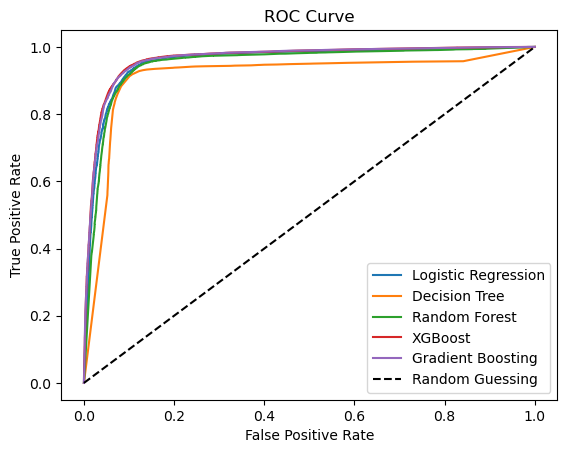

,Model,Accuracy,Precision,Recall,F1 Score,F2 Score,ROC AUC
0,Logistic Regression,0.903546,0.921696,0.882145,0.901485,0.889780,0.956790
1,Decision Tree,0.899338,0.909108,0.887520,0.898184,0.891755,0.905169
2,Random Forest,0.907857,0.905507,0.910870,0.908180,0.909792,0.947992
3,XGBoost,0.918936,0.910052,0.929870,0.919854,0.925838,0.962641
4,Gradient Boosting,0.918594,0.909862,0.929350,0.919502,0.925386,0.962603


In [8]:
X = df.drop(columns=['surgery_flag'])
y = df['surgery_flag']

metrics_obj = generate_classification_models(X, y)
X_test = metrics_obj['X_test']
X_train = metrics_obj['X_train']
y_test = metrics_obj['y_test']
y_train = metrics_obj['y_train']

metrics_obj['metrics']

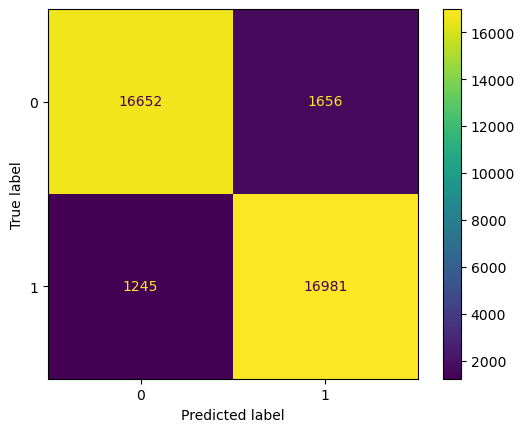

In [9]:
model = metrics_obj['models']['XGBoost']
xgb_confusion = metrics_obj['confusion_matrixes']['XGBoost']
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_confusion, display_labels=model.classes_)
disp.plot()
plt.show()

In [10]:
# pick a model and get the shap values
shap_values = get_shap_values(model, X_test, X_train)

Permutation explainer: 101it [00:11,  1.57it/s]                         


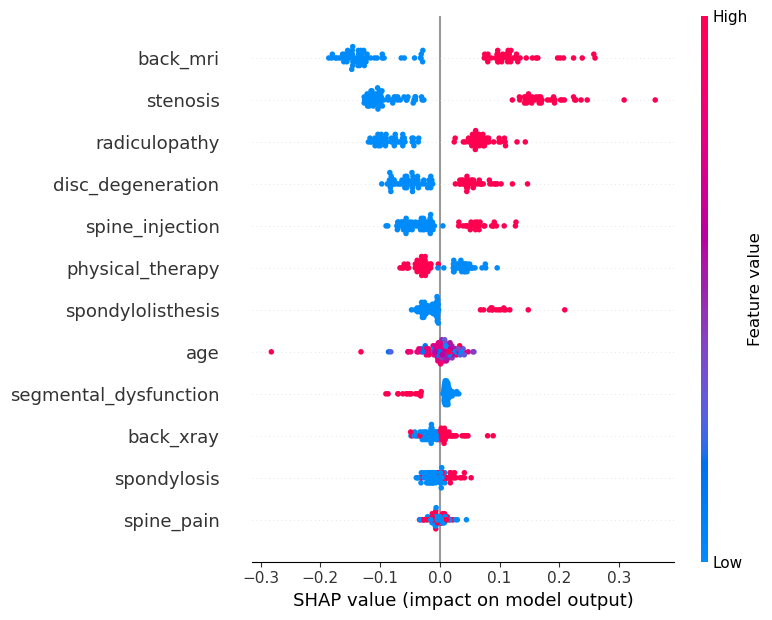

In [11]:
shap.summary_plot(shap_values[:,:,1])

0
age                      23
back_xray                 1
back_mri                  1
spine_injection           1
physical_therapy          1
spine_pain                1
radiculopathy             1
stenosis                  0
disc_degeneration         0
segmental_dysfunction     0
spondylosis               0
spondylolisthesis         0
Name: 144087, dtype: int64


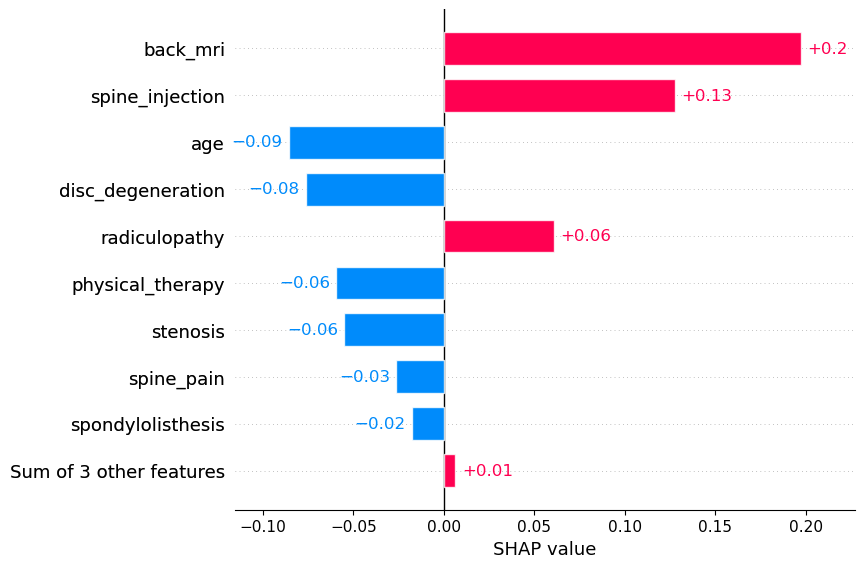

In [12]:
# Grab a random row from the test data and display the shap influence
import random
num = random.randint(0,100)
print(y_test.iloc[num])
print(X_test.iloc[num])
shap.plots.bar(shap_values[num,:,1])

In [13]:
import pickle
pickle.dump(model, open('Back_MSK.pkl','wb'))

0.8996816976127321
0.9304839240645232
0.9135599715333662


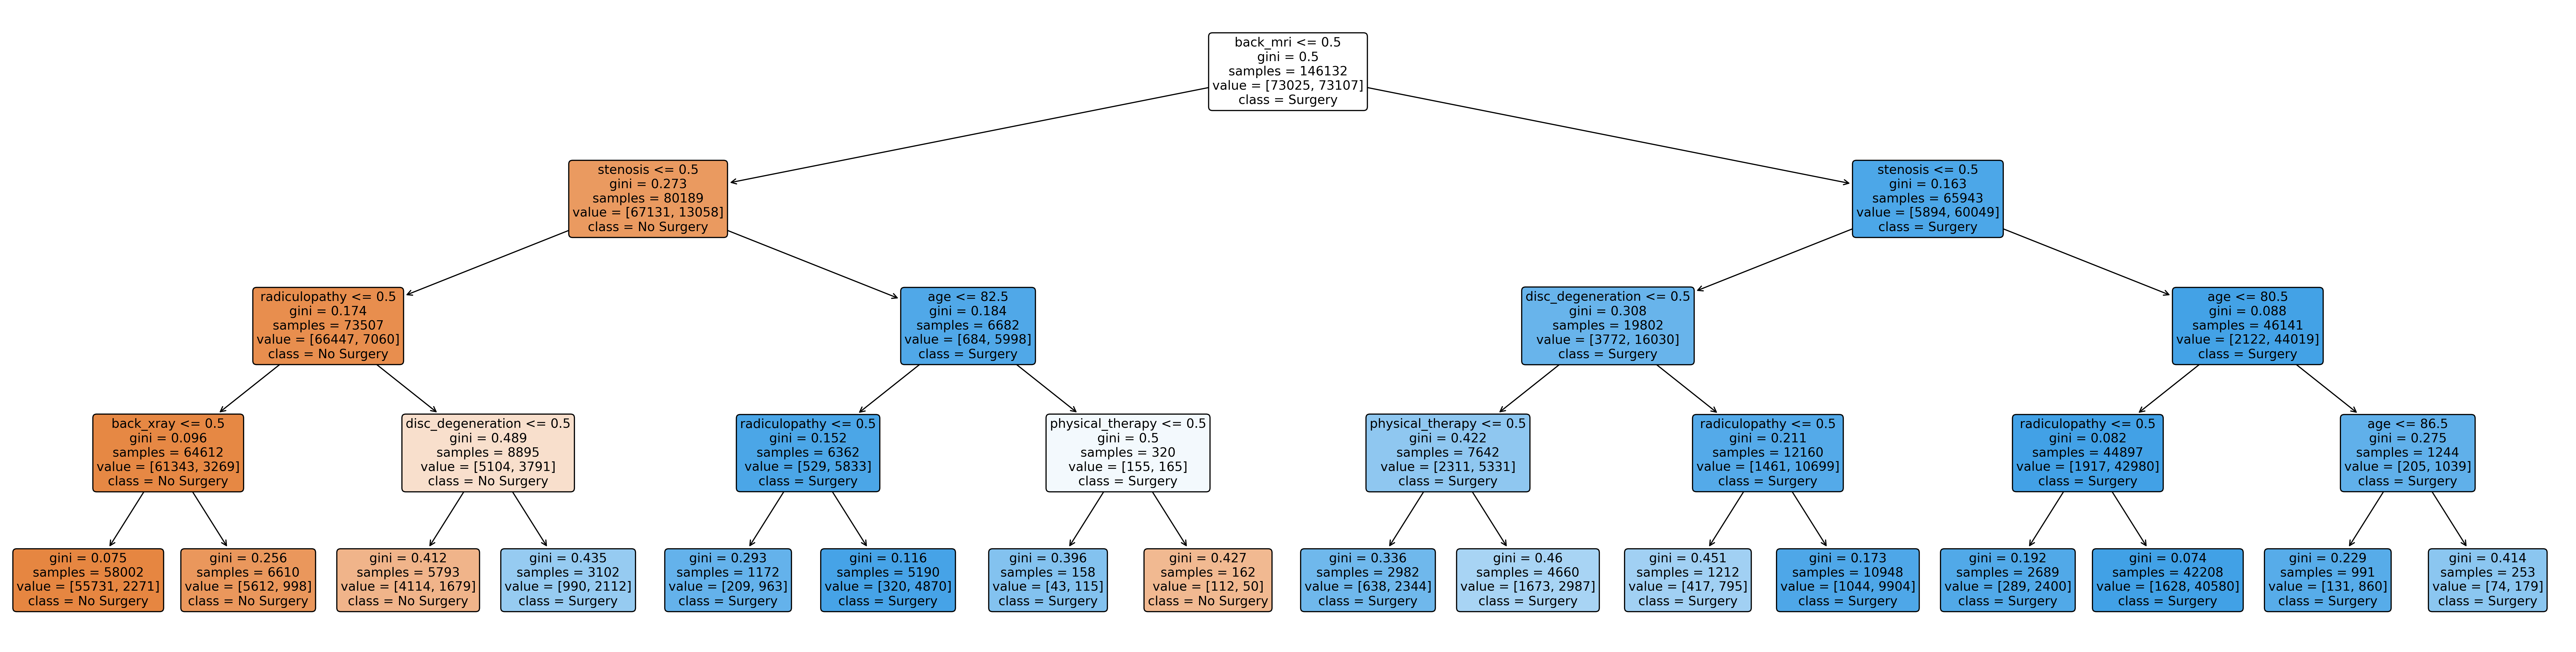

In [15]:
from sklearn import tree
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=42, max_depth=4)
clf.fit(X_train, y_train)

precision = precision_score(y_test, clf.predict(X_test))
recall = recall_score(y_test, clf.predict(X_test))
accuracy = accuracy_score(y_test, clf.predict(X_test))

print(precision)
print(recall)
print(accuracy)

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (40,10), dpi=300)
tree.plot_tree(clf, feature_names=X_train.columns, class_names=['No Surgery', 'Surgery'], filled=True, fontsize=11, rounded=True)
plt.show()

# fig.savefig('depth_4_hip.png')